In [1]:
from IPython.display import Image
from src.model_analysis.networks import GroundedFunctionNetwork as GrFN
from src.model_analysis.visualization import SensitivityVisualizer
from penman import SensitivityModel
from intervaltree import MaxSensitivityTree

# Model Analysis : Iterative Sensitivity Analysis 

## 1. Introduction

- The robustness of any model that is dependent on a set of input variables can be tested by performing a sensitivity analysis.

- Sobol's Method : 
  - Compute Global Sensitivity Indices 
  - Evaluate changes in model output as every single input parameter is varied simultaneously over their respective   spaces 
   - Depends on the ANOVA (Analysis of Variance) representation of a mathematical model where the output variance is decomposed into linear summands of variance in the input parameters.
   - First order measures the variability in model output due to a single parameter
   - Second order measures the variability in model output due to the interaction between 2 parameters
   - Sobol Indices computed from Sobol analysis can determine the extent to which a parameter affects variations in output. It cannot determine the cause of such an effect
   - Cut-off : 0.01

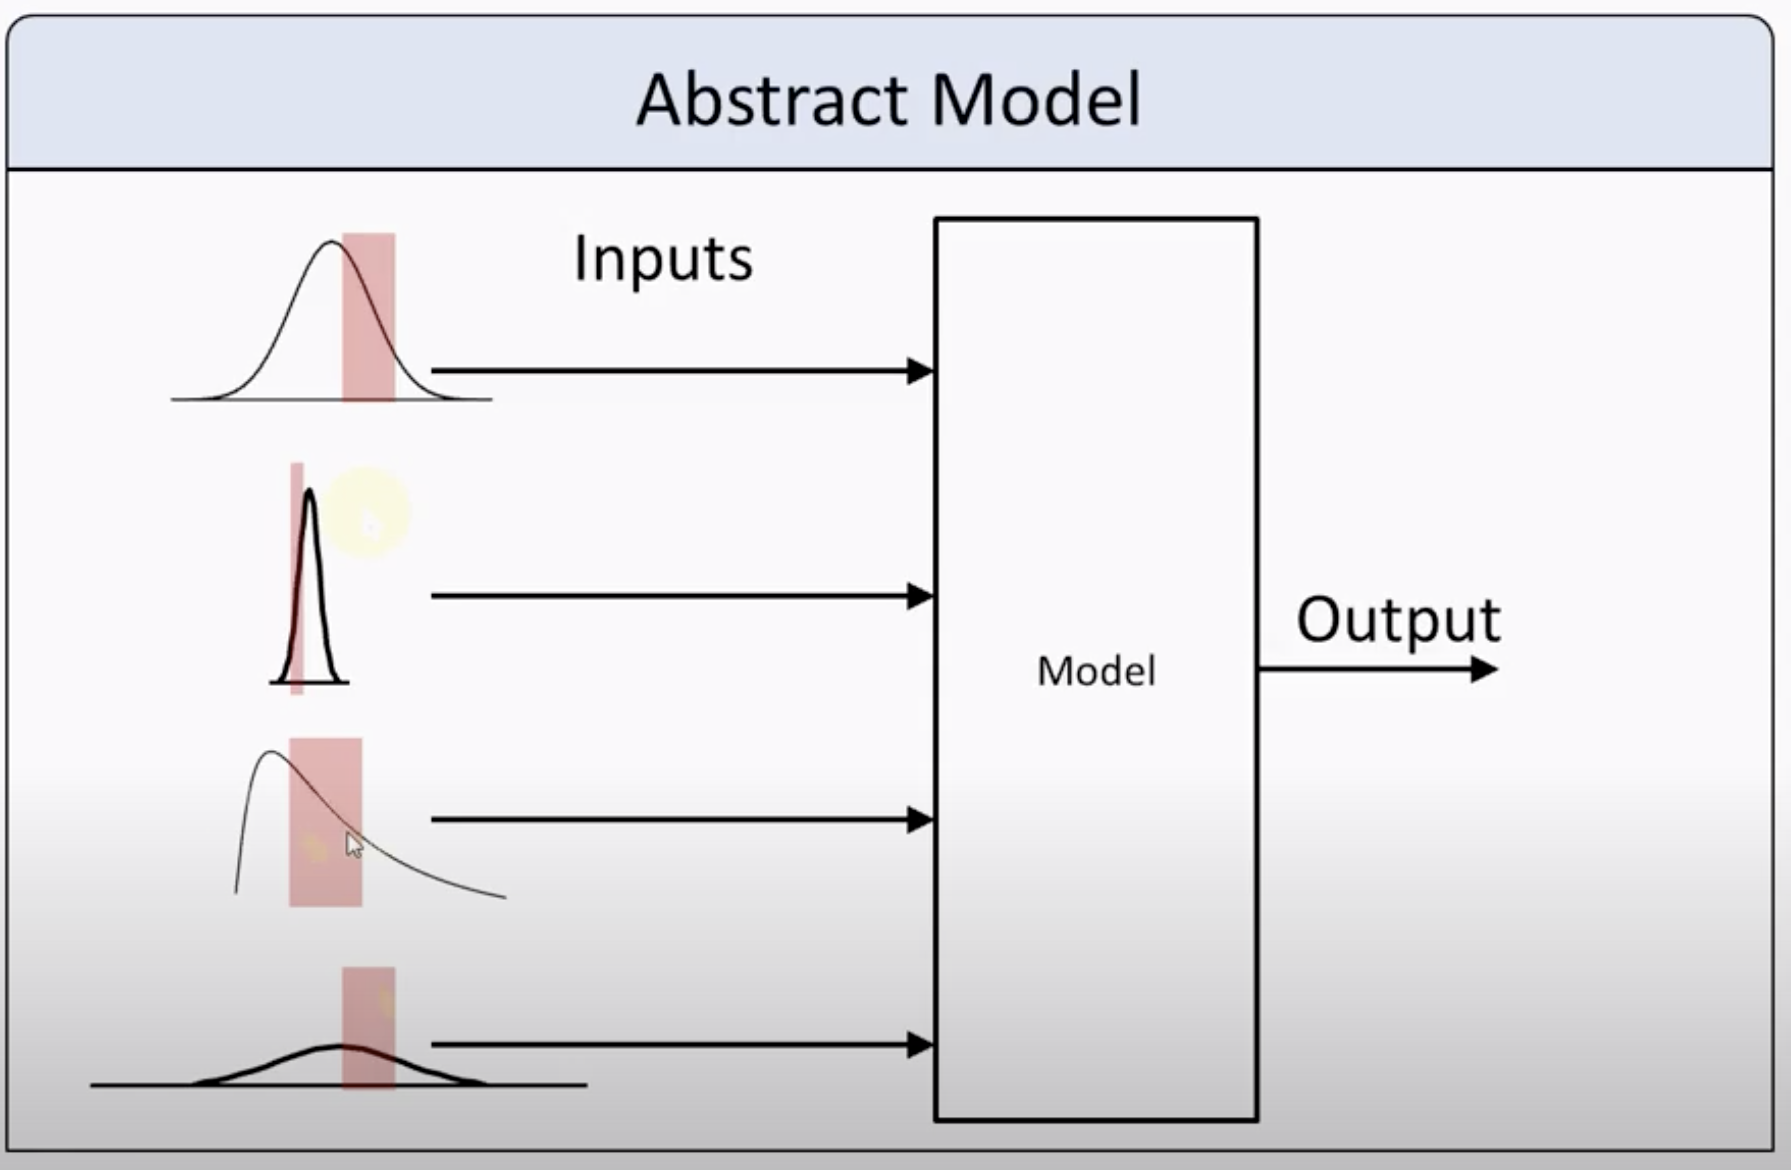

In [12]:
Image('sensitivity.png', width=600,  height=600)

## 2. Sobol Indices : PETPT Model

### List of Sample Sizes 

sample_list = [10**x for x in range(1, 2)]

### Sobol 

method = 'Sobol'

### Bounds

bounds = {
        'tmax':[-30.0, 60.0],
        'tmin':[-30.0, 60.0],
        'srad': [0.0, 30.0],
        'msalb': [0.0, 1.0],
        'xhlai': [0.0, 20.0]
    }

### First Order Sobol Index : S1

- *Plot of First Order Sobol Indices of input parameters in PETPT models usling SALib library as a function of the log of sample sizes. Since the computation of Sobol Indices is dependent on a quasi-Monte Carlo method, a large sample size (N => 4, log scale) is necessary for an accurate estimation of the indices. Our result indicates that TMAX is the most dominant parameter with the largest first order Sobol Index ($\sim 0.6$) followed by the solar radiation (SRAD).*

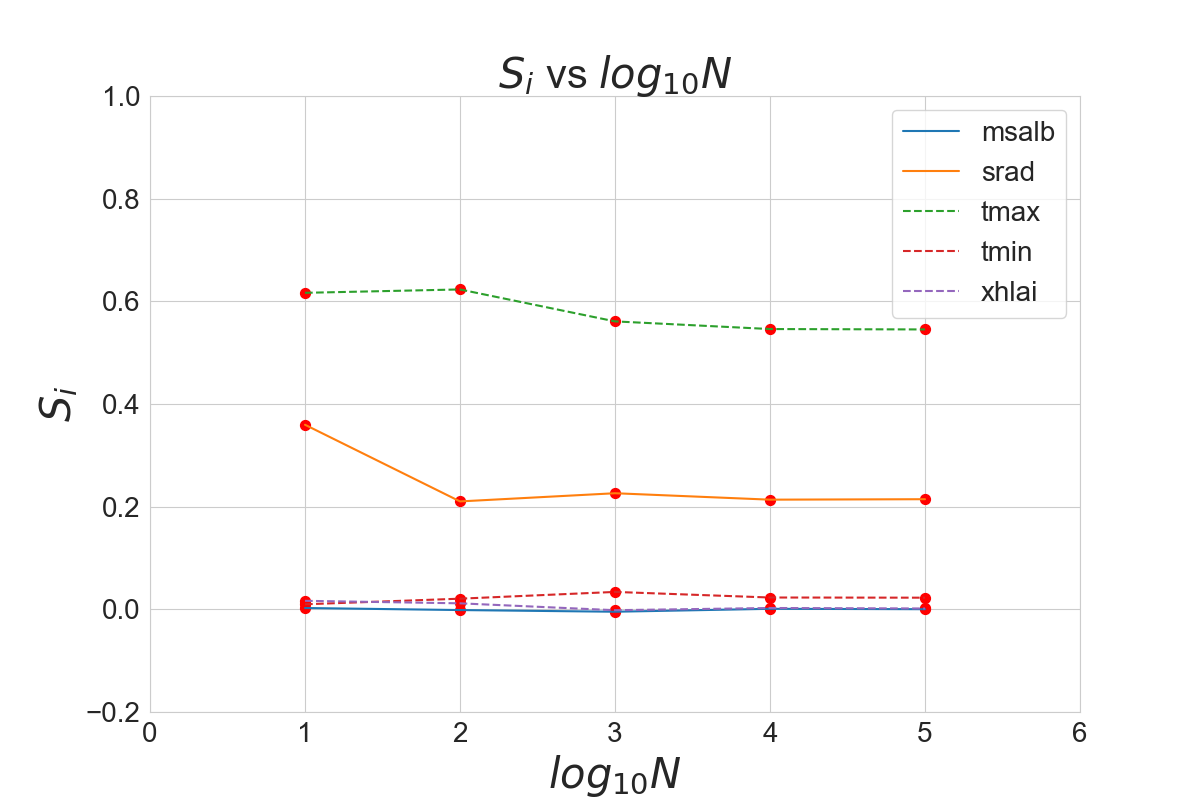

In [9]:
Image('PETPT_S1.png', width=1000,  height=1000)

### Second Order Sobol Index : S2

- *The lower triangular matrix represents the Second Order Sobol Indices of the PETPT model for sample size = 5 (log scale). Largest index ($S_{ij}$) stems from the interaction of TMAX with SRAD.*

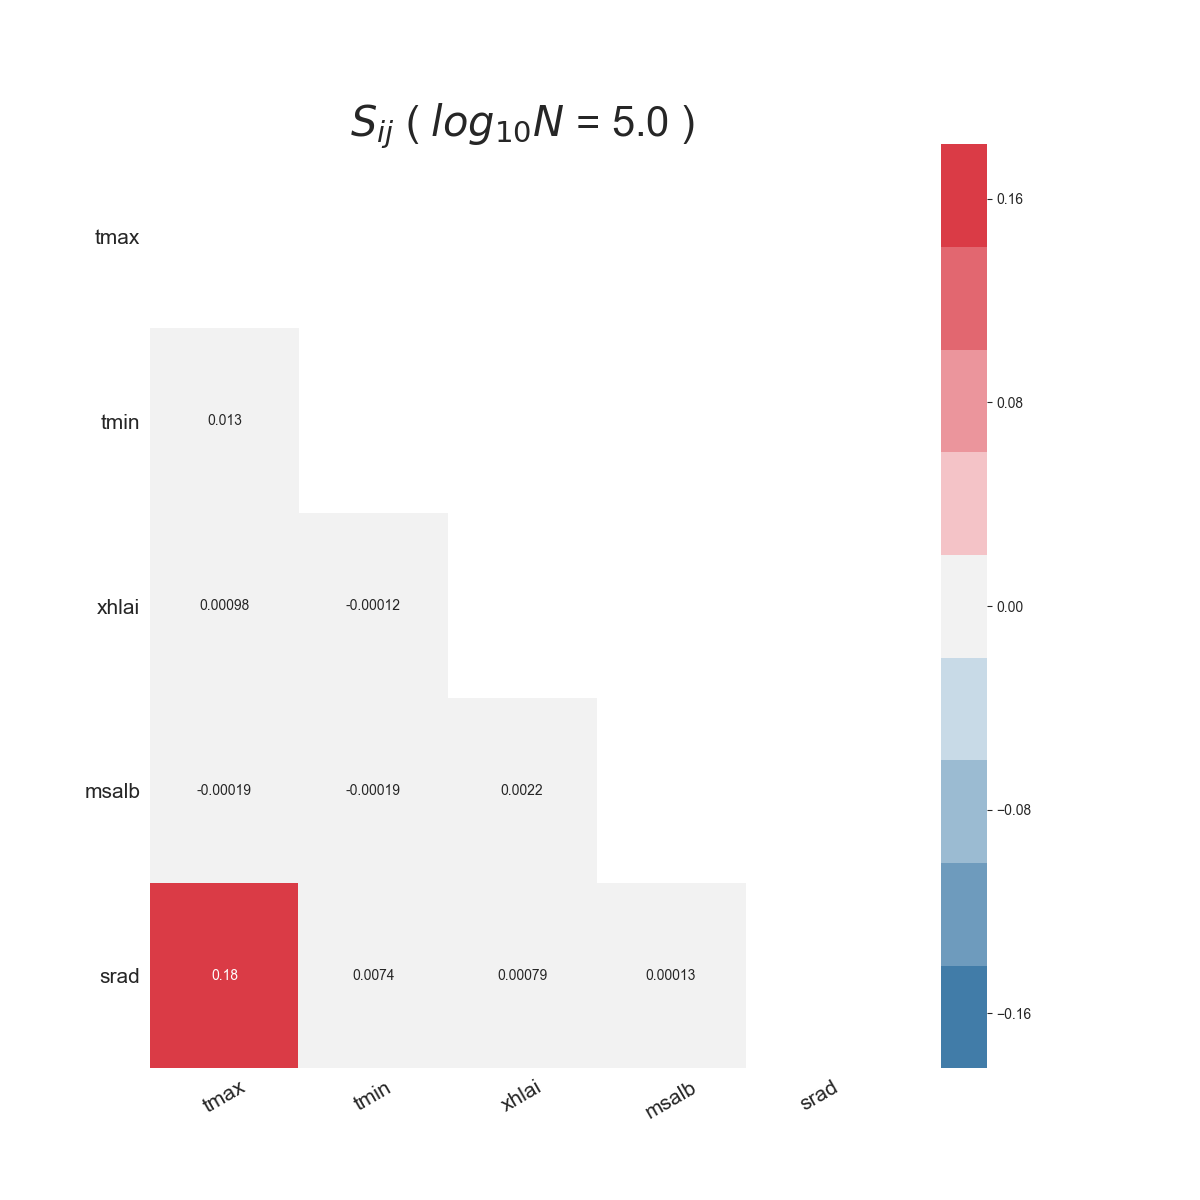

In [10]:
Image('PETPT_S2.png', width=1000,  height=1000)

### Runtime of Computation

- *Computation of Sensitivity Indices has three components - sampling, execution, and analysis. 'Sampling Time' depends on the size of the sample as well as input variable vector size. If one wishes to compute the second order indices, the total number of samples is increased. Once the samples have been generated, model outputs are generated from the input bounds and GrFN. The time taken to carry it out is given by 'Execution Time'. Finally, computation of indices is performed and the time taken to do so is given by the 'Analysis Time'. The speed of computation can be greatly enhanced if one were to use FAST and RBD-FAST methods. The disadvantage of using these techniques is the inability to calculate second order indices. Hence, we are only restricted to calculating the first and total order if such methods were to be implemented.*

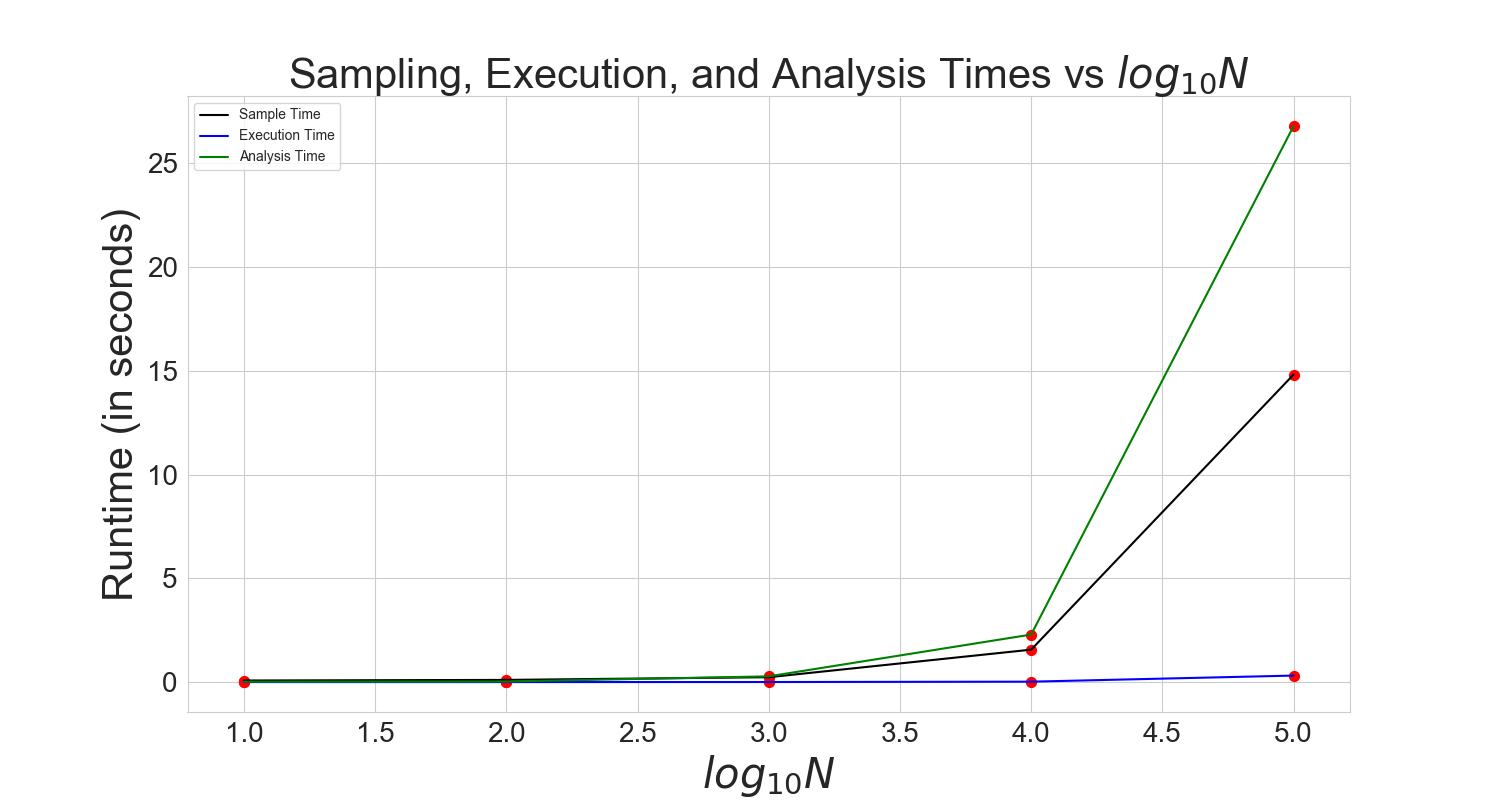

In [11]:
Image('PETPT_runtime.png', width=1000,  height=1000)

## 3. Iterative Sensitivity Analysis (ISA)

### Detecting Conditional Statements in Model :  Static Code  Analysis

```fortran
      SLANG = SRAD*23.923
      EEQ = SLANG*(2.04E-4-1.83E-4*ALBEDO)*(TD+29.0)
      EO = EEQ*1.1

      IF (TMAX .GT. 35.0) THEN
        EO = EEQ*((TMAX-35.0)*0.05+1.1)
      ELSE IF (TMAX .LT. 5.0) THEN
        EO = EEQ*0.01*EXP(0.18*(TMAX+20.0))
      ENDIF

      EO = MAX(EO,0.0001)
```

- Different intervals of TMAX will lead to different functional forms of model output (EO). Since, TMAX is the most dominant variable in causing significant variations in model output, i.e. max $S_{1}$, we would like to see the effect 
on sobol indices by choosing a different set of bounds for TMAX.

- AutoMATES can detect this using static code analysis on the conditional variables included in the model code.
- Split the interval of TMAX into three contiguous intervals

    1. -30.0$^{\circ}$C -- 5.0$^{\circ}$C
    2. $\color{red} {5.0^{\circ}C -- 35.0^{\circ}C}$
    3. 35.0$^{\circ}$C -- 60.0$^{\circ}$C

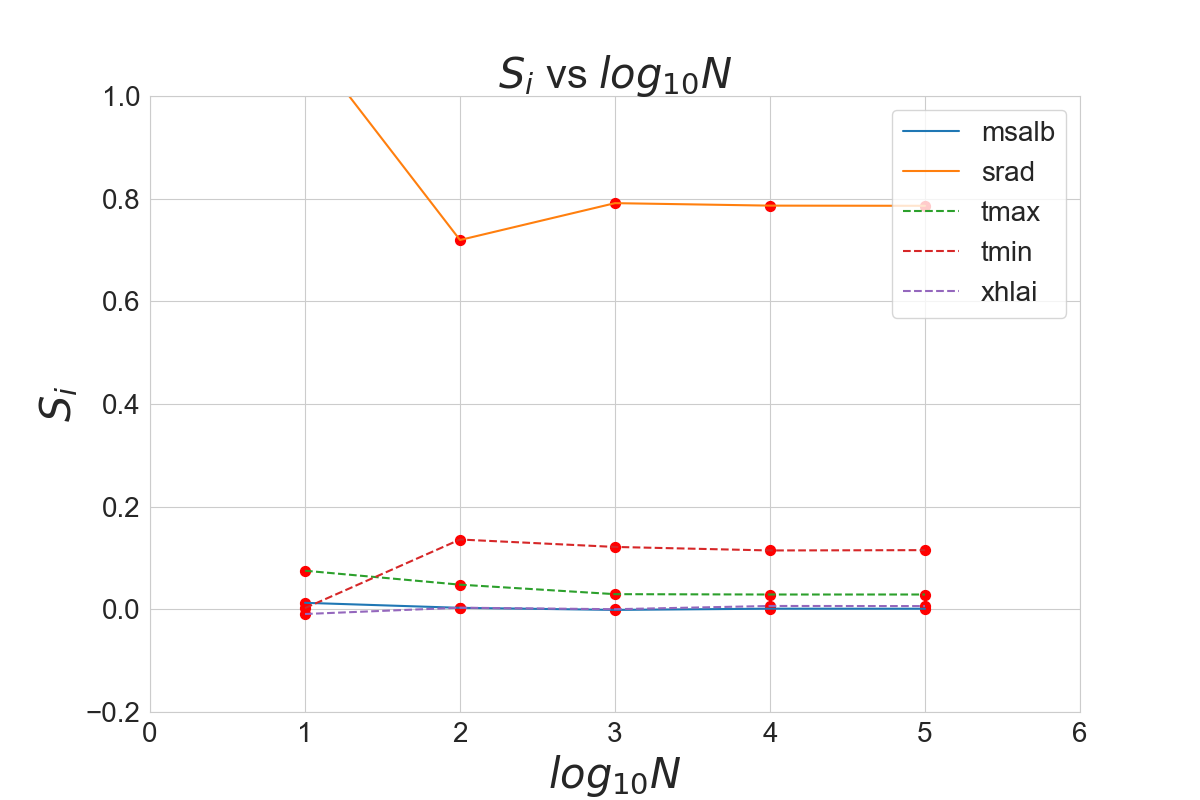

In [24]:
Image('PETPT_S1new.png', width=1000,  height=1000)

### Generating the Max Sensitivity Tree

#### Algorithm
   - Determine the parameter with the largest $S_1$ index
   - Check if this parameter appears in any conditional statements. If it does appear, split interval based on condition otherwise split original interval into three contiguous equal intervals
   - Repeat Step 1 for each interval (node in the tree). If max  $S_1$ is given by the same variable then the interval is not split any further. If max $S_1$ is given by a new variable, then the interval is split based on Step 2.
   -  This process is repeated till all nodes have been explored or once a certain number of tree levels (threshold) have been generated.

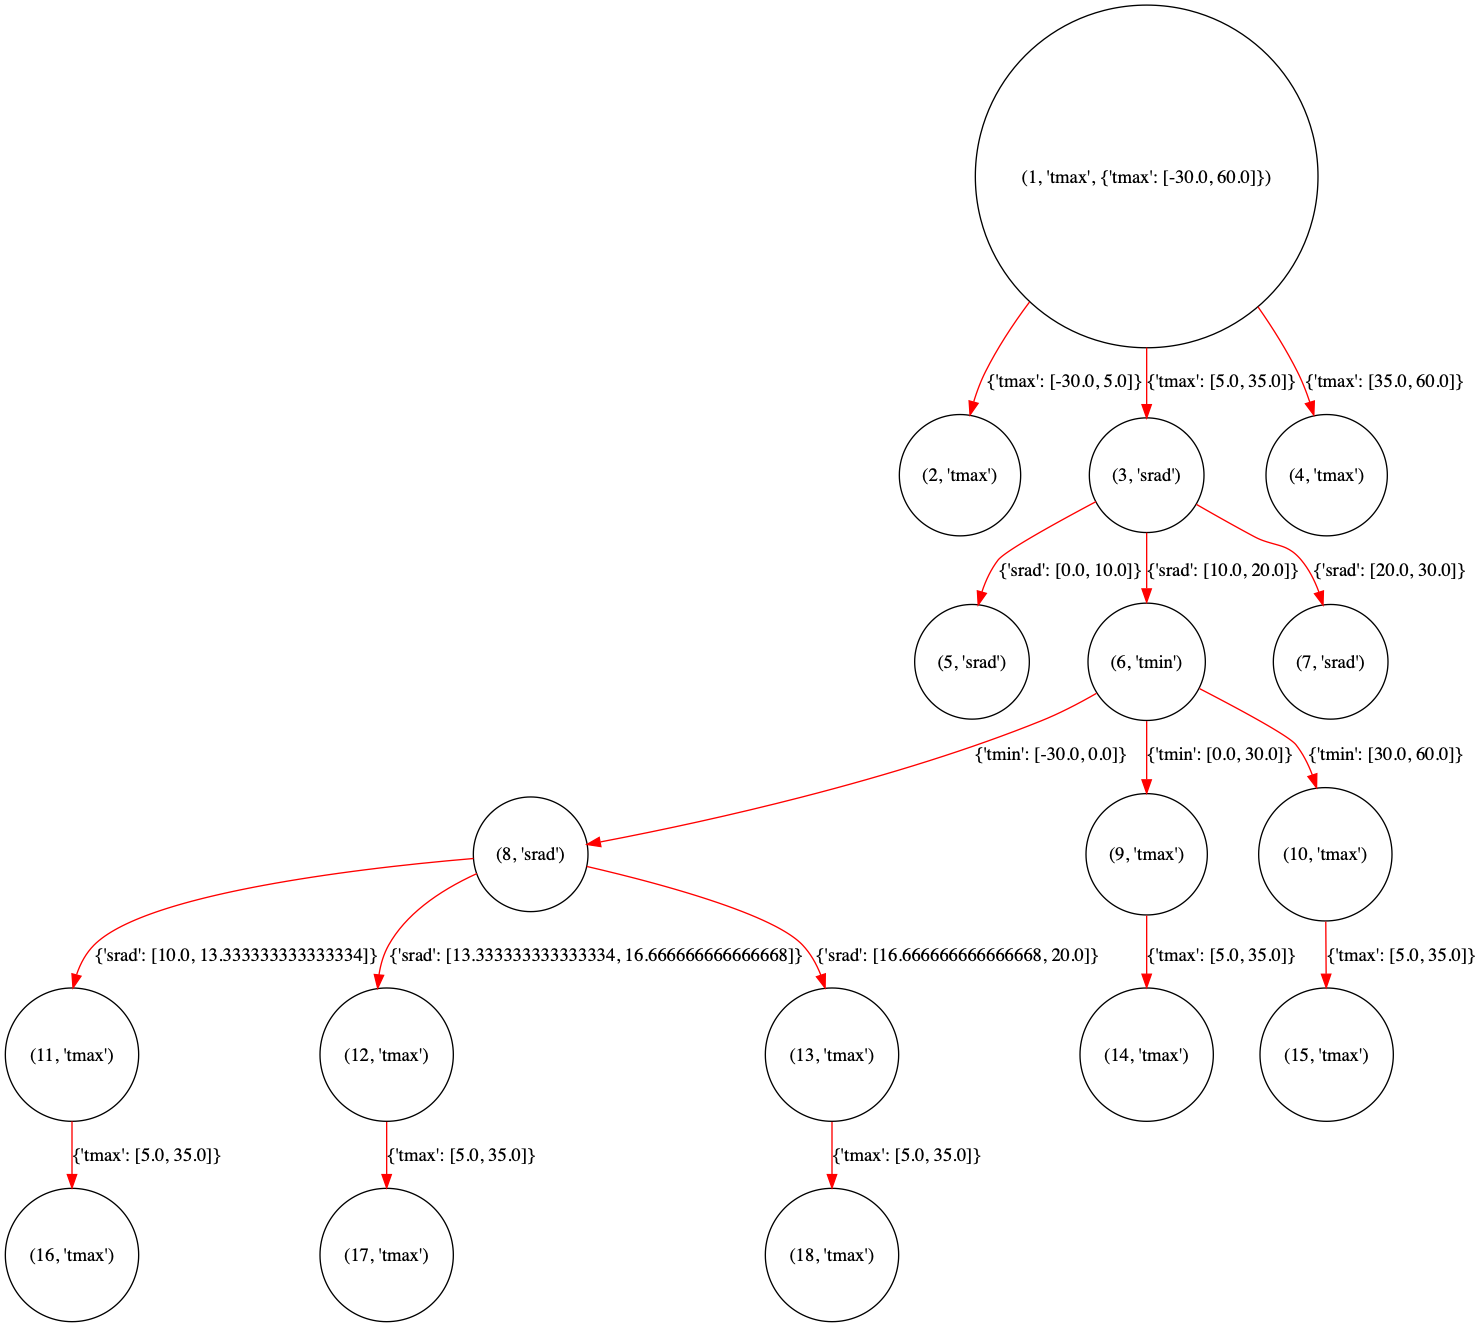

In [22]:
Image('PETPT.png', width=1000,  height=1000)

### Bar Plot of Sensitivity Indices for a given Node

- node = '3' : SRAD has the largest S1 index; sample size (log scale) = 5 

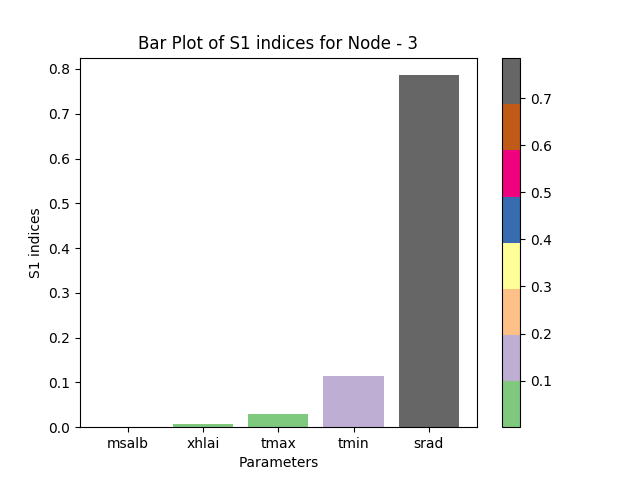

In [25]:
Image('PETPT_barplot.png', width=1000,  height=1000)